In [1]:
import pickle

from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
DATA = '../../../../data'

In [3]:
def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word 
        fr_embeddings:
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the
        rows on the list
    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:, :]
    return X

In [4]:
data = pd.read_csv(f'{DATA}/capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']
data.head()

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [5]:
data.shape

(4721, 4)

In [6]:
embeddings = KeyedVectors.load_word2vec_format(
    f'{DATA}/GoogleNews-vectors-negative300.bin', binary=True)

In [7]:
f = open(f'{DATA}/capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
select_words = words = [
    'king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 
    'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)

In [8]:
def get_word_embeddings(embeddings):
    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings

In [9]:
word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))
pickle.dump(word_embeddings, open('word_embeddings_subset.pkl', 'wb'))

245


In [10]:
word_embeddings = pickle.load(open('word_embeddings_subset.pkl', 'rb'))
len(word_embeddings)

245

In [11]:
print('Dim:', word_embeddings['Spain'].shape[0])

Dim: 300


The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

In [12]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between 
          A and B.
    '''
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)
    return cos

In [13]:
king = word_embeddings['king']
queen = word_embeddings['queen']
cosine_similarity(king, queen)

0.6510956

In [14]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """
    d = np.sqrt(((A - B)**2).sum())
    return d

In [15]:
euclidean(king, queen)

2.4796925

In [27]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are 
          their embeddings
    Output:
        countries: a dictionary with the most likely country and its 
          similarity score
    """
    group = set((city1, country1, city2))
    city1_emb = embeddings[city1]
    city2_emb = embeddings[city2]
    country1_emb = embeddings[country1]
    # get expected embedding of country 2
    vec = city2_emb - city1_emb + country1_emb
    similarity = -1
    country = ''
    for word in embeddings.keys():
        if word not in group:
            word_emb = embeddings[word]
            cur_similarity = cosine_similarity(vec, word_emb)
            if cur_similarity > similarity:
                similarity = cur_similarity
                country = (word, similarity)
    return country

In [28]:
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [29]:
for i, row in data.iterrows():
    print(i)
    print(row)
    break

0
city1         Athens
country1      Greece
city2        Bangkok
country2    Thailand
Name: 0, dtype: object


In [32]:
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the 
          value is its embedding
        data: a pandas dataframe containing all the country and capital 
          city pairs
    Output:
        accuracy: the accuracy of the model
    '''
    n_correct = 0
    for i, row in data.iterrows():
        try:
            city1 = row.city1
            country1 = row.country1
            city2 =  row.city2
            country2 = row.country2
            predicted_country2, _ = get_country(
                city1, country1, city2, word_embeddings)
            if predicted_country2 == country2:
                n_correct += 1
        except KeyError:
            continue
    m = len(data)
    accuracy = n_correct / m
    return accuracy

In [33]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


In [115]:
X = np.random.rand(3, 10)
X_centered = X - X.mean()
sigma = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(sigma)
#print(eigvals)
#print(eigvecs)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
n_comp = 2
eigvecs = eigvecs[:, :n_comp]
print(X_centered.shape, eigvecs.shape)
#X_centered @ eigvecs.T
#(eigvecs @ X_centered.T).T
(eigvecs.T @ X_centered.T).T

(3, 10) (10, 2)


array([[-0.32535189,  0.74300641],
       [-0.77431099, -0.23783189],
       [ 0.61376059, -0.03124694]])

In [118]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m, n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated 
          original data
    """
    X_centered = X - X.mean()
    covariance_matrix = np.cov(X_centered, rowvar=False)
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)
    idx = np.argsort(eigen_vals)[::-1]
    eigen_vals_sorted = eigen_vals[idx]
    eigen_vecs_sorted = eigen_vecs[:, idx]
    eigen_vecs_subset = eigen_vecs_sorted[:, :n_components]
    X_reduced = (eigen_vecs_subset.T @ X_centered.T).T
    return X_reduced

In [119]:
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.23132424  0.43767745]
 [ 0.2177235  -0.56404087]
 [-1.0581947  -0.05521575]]


In [120]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all
# the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', 
      X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


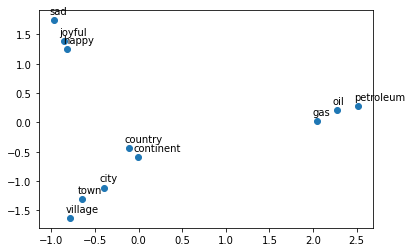

In [121]:
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))